
Let's load our pre-trained weights into the model now:

In [1]:
import os 

import pandas as pd 
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score, roc_curve

os.chdir("../../")

In [2]:

from helpers.helpers.df_ops.df_ops import check_for_leakage, remove_data_leakage 
from helpers.helpers.ai.io import get_train_generator, get_test_and_valid_generator
from helpers.helpers.ai.loss import compute_class_freqs, get_weighted_loss

In [3]:
# Define constants here
    
IMAGE_DIR  = "data/nih/images-small/"
LABELS = ['Cardiomegaly', 
        'Emphysema', 
        'Effusion', 
        'Hernia', 
        'Infiltration', 
        'Mass', 
        'Nodule', 
        'Atelectasis',
        'Pneumothorax',
        'Pleural_Thickening', 
        'Pneumonia', 
        'Fibrosis', 
        'Edema', 
        'Consolidation']

WEIGHTS_DIR = 'data/nih/models/densenet.hdf5'
PRETRAINED_MODEL_DIR = 'data/nih/models/pretrained_model.h5'

OUTPUT_DIR = "data/output/chest_xray_diagnosis/"


In [4]:

def create_model(loss):
    base_model = DenseNet121(weights= WEIGHTS_DIR, include_top=False)
        
    x = base_model.output

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = Dense(len(LABELS), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss = loss)

    return model

In [5]:

# Read in data
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df = pd.read_csv("data/nih/test-small.csv")

# Check for leakage
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

if check_for_leakage(train_df, valid_df, "PatientId"):
    print("checking for leakage between train and valid set...")
    train_df, valid_df = remove_data_leakage(train_df, valid_df, "PatientId")


if check_for_leakage(train_df, test_df, "PatientId"):
    print("checking for leakage between train and test set...")
    train_df, test_df = remove_data_leakage(train_df, test_df, "PatientId")

# Get generators
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", LABELS)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", LABELS)

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)    
pos_weights = freq_neg
neg_weights = freq_pos

loss =  get_weighted_loss(pos_weights, neg_weights)
model = create_model(loss)

leakage between train and valid: True
leakage between train and test: False
leakage between valid and test: False
checking for leakage between train and valid set...
There are 11 patients in both train and valid set.
These are the indices of overlapping patients in the training set: 
[306, 186, 797, 98, 408, 917, 327, 913, 10, 51, 276]
These are the indices of overlapping patients in the validation set: 
[104, 88, 65, 13, 2, 41, 56, 70, 26, 75, 20, 52, 55]
After removing overlapping patients, there are 96 samples in the validation set.
getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 0 validated image filenames.
Found 420 validated image filenames.


e:\medsoft\Learning\ai_in_medicine\env\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 96 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


In [6]:
model.load_weights(PRETRAINED_MODEL_DIR)

In [7]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

C:\Users\Future\AppData\Local\Temp\ipykernel_19820\2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


### ROC Curve and AUROC
We'll cover topic of model evaluation in much more detail in later weeks, but for now we'll walk through computing a metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. This is also referred to as the AUROC value, but you will see all three terms in reference to the technique, and often used almost interchangeably. 

For now, what you need to know in order to interpret the plot is that a curve that is more to the left and the top has more "area" under it, and indicates that the model is performing better.

We will use the `util.get_roc_curve()` function which has been provided for you in `util.py`. Look through this function and note the use of the `sklearn` library functions to generate the ROC curves and AUROC values for our model. 

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

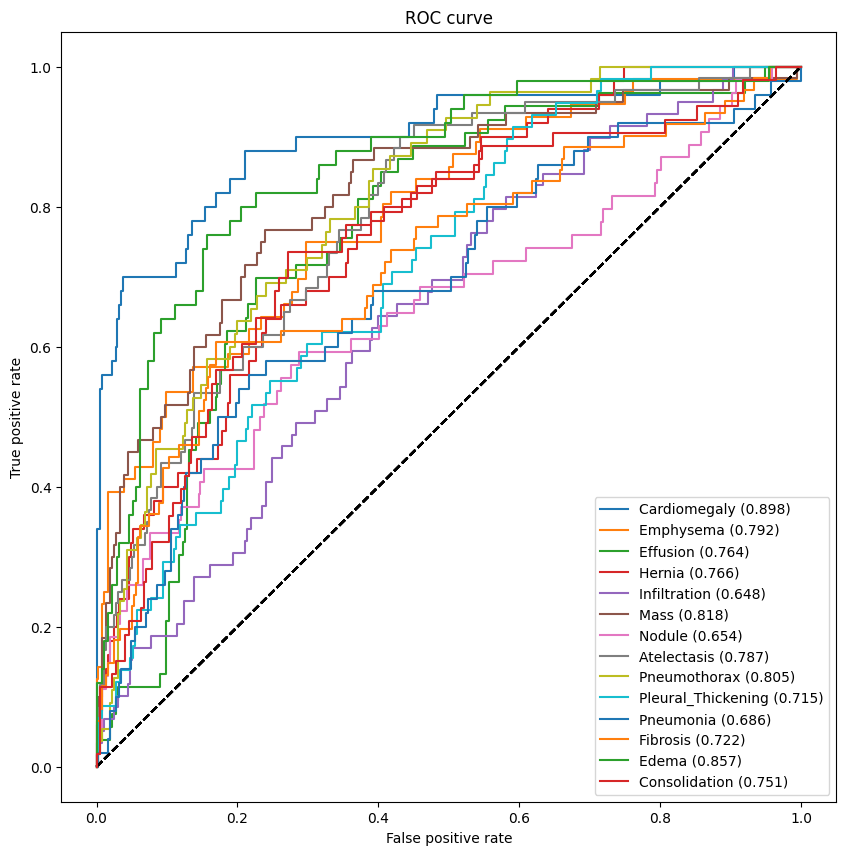

In [8]:
from helpers.helpers.evaluations.performance_metrics import get_roc_curve
auc_rocs = get_roc_curve(LABELS, predicted_vals, test_generator)

### Visualizing Learning with GradCAM 

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

In this section we will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided for you in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [9]:
import numpy as np 
df = pd.read_csv("data/nih/train-small.csv")
IMAGE_DIR = "data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(LABELS, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
from helpers.helpers.visualization.grad_cam import compute_gradcam
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, LABELS, labels_to_show)